In [1]:
data_folder = "../data/"

In [2]:
from pathlib import Path
import pandas as pd

In [3]:
data_folder_path = Path(data_folder)

In [4]:
target_stocks = [
    "AAPL",
    "GOOGL",
    "AMZN",
    "TSLA",
    "NVDA",
    "MSFT",
    "META"
]

In [5]:
def read_and_concat_all_stocks(data_folder_path):
    data_list = []
    for ticker_path in data_folder_path.glob("*"):
        ticker = ticker_path.stem
        most_recent_stock_data = sorted(ticker_path.glob(f"{ticker}_*"))[-1]
        data_list.append(pd.read_csv(str(most_recent_stock_data), index_col="Date", parse_dates=True))

    return pd.concat(data_list, axis=1)

In [6]:
data = read_and_concat_all_stocks(data_folder_path)

In [7]:
def time_series_train_test_split(X, y, validation_window=10):
    
    return X[:-validation_window], X[-validation_window:], y[:-validation_window], y[-validation_window:]

In [8]:
def add_date_as_feature(data):
    return pd.concat([
        data,
        pd.DataFrame({
            'year': data.index.year,
            'month': data.index.month,
            'weekday': data.index.weekday
        }, index=data.index)
    ], axis=1).reset_index(drop=True)

In [9]:
data = add_date_as_feature(data)

In [10]:
def separate_the_target_column(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [17]:
X_train_raw = data[["MSFT", "GOOGL", "AMD", "AMZN", "year", "month", "weekday"]]
y_train_raw = data["AAPL"]

In [ ]:
X_train_raw = data.drop("AAPL", axis=1)
y_train_raw = data["AAPL"]

In [18]:
X_train_raw.shape

(3909, 7)

In [21]:
input_size = 7 

In [22]:
import torch
import numpy as np

In [23]:
def create_lstm_dataset(X_raw, y_raw, window = 30):
    X, y = [], []

    X_raw = X_raw.to_numpy()
    y_raw = y_raw.to_numpy()
    for i in range(len(X_raw) - window):
        X.append(X_raw[i:i+window])  
        y.append(y_raw[i+window])  

    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

In [27]:
def prepare_data_for_lstm_training(data_folder_path, target_column, validation_window=30, lstm_window=30):

    data = read_and_concat_all_stocks(data_folder_path)
    
    data = add_date_as_feature(data)

    X, y = separate_the_target_column(data=data,
                                      target_column=target_column) 

    X = X[["MSFT", "GOOGL", "AMD", "AMZN", "year", "month", "weekday"]]

    X_raw, y_raw = create_lstm_dataset(X, y, window=lstm_window)
    
    X_train, X_valid, y_train, y_valid = time_series_train_test_split(X=X_raw,
                                                                      y=y_raw,
                                                                      validation_window=validation_window)
    return X_train, X_valid, y_train, y_valid
    

In [28]:
X_train, X_valid, y_train, y_valid = prepare_data_for_lstm_training(data_folder_path, "AAPL")

In [29]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

(torch.Size([3849, 30, 7]),
 torch.Size([30, 30, 7]),
 torch.Size([3849]),
 torch.Size([30]))

In [30]:
import torch
import torch.nn as nn

In [38]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)

        # MLP head for regression
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_size]
        last_hidden = lstm_out[:, -1, :]  # take last timestep
        out = self.head(last_hidden)  # [batch_size, 1]
        return out.squeeze(1)  # [batch_size]

In [39]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=16)
valid_dl = DataLoader(valid_ds, batch_size=16)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMRegressor(input_size=input_size, hidden_size=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    train_loss = 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = criterion(pred, yb)  # 🚫 No weights here

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        for xb, yb in valid_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            valid_loss += loss.item() * xb.size(0)
        valid_loss /= len(valid_dl.dataset)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {valid_loss:.4f}")

Epoch 1: Train Loss = 2562.7143, Val Loss = 5755.6846
Epoch 2: Train Loss = 6108.3168, Val Loss = 10642.2376


KeyboardInterrupt: 

In [46]:
X_train_cpu = X_train.to(device)
y_train_cpu = y_train.to(device)

In [47]:
with torch.no_grad():
    y_train_pred = model(X_train_cpu)

In [48]:
import matplotlib.pyplot as plt

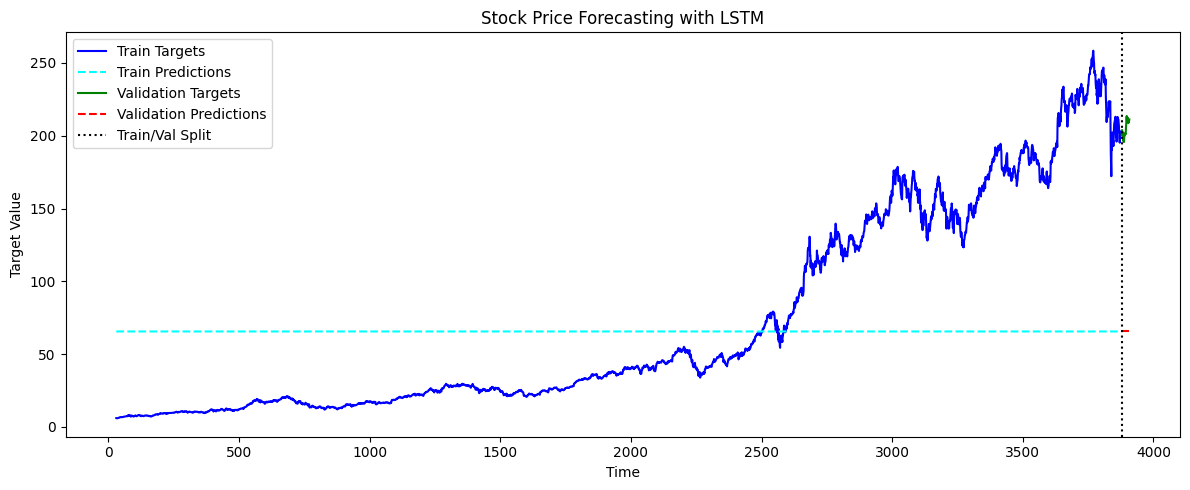

In [49]:
# 1. Move model and data to appropriate device
model.eval()
X_train_cpu = X_train.to(device)
y_train_cpu = y_train.to(device)
X_valid_cpu = X_valid.to(device)
y_valid_cpu = y_valid.to(device)

# 2. Predict outputs
with torch.no_grad():
    y_train_pred = model(X_train_cpu)
    y_valid_pred = model(X_valid_cpu)

# 3. Convert to numpy
y_train_true = y_train_cpu.cpu().numpy()
y_train_pred = y_train_pred.cpu().numpy()
y_valid_true = y_valid_cpu.cpu().numpy()
y_valid_pred = y_valid_pred.cpu().numpy()

# 4. Plot
plt.figure(figsize=(12, 5))

# Training target
train_end = len(y_train_true) + 30  # assumes window size = 30
plt.plot(range(30, train_end), y_train_true, label="Train Targets", color="blue")
plt.plot(range(30, train_end), y_train_pred, label="Train Predictions", color="cyan", linestyle='--')

# Validation target
val_start = train_end
val_end = val_start + len(y_valid_true)
plt.plot(range(val_start, val_end), y_valid_true, label="Validation Targets", color="green")
plt.plot(range(val_start, val_end), y_valid_pred, label="Validation Predictions", color="red", linestyle='--')

# Split marker
plt.axvline(train_end, color='black', linestyle=':', label="Train/Val Split")

plt.xlabel("Time")
plt.ylabel("Target Value")
plt.legend()
plt.title("Stock Price Forecasting with LSTM")
plt.tight_layout()
plt.show()